## <font color=purple>Import needed modules</font>

In [1]:
#general libraries needed
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy import stats

#scikit learn imports
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

#give yourself the opportunity to visualize the pipeline and models
from sklearn import set_config
set_config(display='diagram')

## <font color=purple>Function Definitions</font>

In [2]:
#function that shows a learning curve for any model that has predict or fit methods
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator,X,y,ylim=None,cv=None,n_jobs=None,train_sizes=np.linspace(0.1, 1.0, 20),scoring = 'neg_root_mean_squared_error'):
    
    _, axes = plt.subplots(1, 1, figsize=(10, 5))    
    axes.set_title('Learning Curve')
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel(scoring)

    train_sizes, train_scores, test_scores= learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes,scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes,train_scores_mean - train_scores_std,train_scores_mean + train_scores_std,alpha=0.1,color="r")
    axes.fill_between(train_sizes,test_scores_mean - test_scores_std,test_scores_mean + test_scores_std,alpha=0.1,color="g")
    axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    axes.legend(loc="best")
    plt.show()
    
    return

#code to prevent warnings that can occur as a result of this function
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [3]:
#function to verify the existence of a file in the current working directory and download it if not
import os,urllib, urllib.request, sys, tarfile
def downloadDataResource(file,sourcePath,compressed=None):
    if not os.path.isfile(file):
        try:
            urllib.request.urlretrieve(sourcePath+(compressed if compressed else file),(compressed if compressed else file))
            print("Downloaded", (compressed if compressed else file) )
            if compressed:
                ucomp = tarfile.open(compressed)
                ucomp.extractall()
                ucomp.close()
                print("File uncompressed.")
        except:
            print("ERROR: File", (compressed if compressed else file), "not found. Data source missing.")
    else:
        print("Data resource", file, "already downloaded.")

## <font color=purple>Source Data

In [4]:
#download data files if not currently downloaded into the current working directory
path = "https://raw.githubusercontent.com/sarahwhynott/Machine-Learning/main/"
filename = "sephora_website_dataset.csv"


path2 = "https://raw.githubusercontent.com/sarahwhynott/Machine-Learning/main/"
filename2 = "product_info.csv"


downloadDataResource(filename, path)
downloadDataResource(filename2, path2)

Data resource sephora_website_dataset.csv already downloaded.
Data resource product_info.csv already downloaded.


In [5]:
#create a dataframe with the data from the CSV file
df = pd.read_csv(filename)
df2 = pd.read_csv(filename2)

## <font color=purple>Transform Data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9168 entries, 0 to 9167
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      9168 non-null   int64  
 1   brand                   9168 non-null   object 
 2   category                9168 non-null   object 
 3   name                    9168 non-null   object 
 4   size                    9168 non-null   object 
 5   rating                  9168 non-null   float64
 6   number_of_reviews       9168 non-null   int64  
 7   love                    9168 non-null   int64  
 8   price                   9168 non-null   float64
 9   value_price             9168 non-null   float64
 10  URL                     9168 non-null   object 
 11  MarketingFlags          9168 non-null   bool   
 12  MarketingFlags_content  9168 non-null   object 
 13  options                 9168 non-null   object 
 14  details                 9168 non-null   

In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          8494 non-null   object 
 1   product_name        8494 non-null   object 
 2   brand_id            8494 non-null   int64  
 3   brand_name          8494 non-null   object 
 4   loves_count         8494 non-null   int64  
 5   rating              8216 non-null   float64
 6   reviews             8216 non-null   float64
 7   size                6863 non-null   object 
 8   variation_type      7050 non-null   object 
 9   variation_value     6896 non-null   object 
 10  variation_desc      1250 non-null   object 
 11  ingredients         7549 non-null   object 
 12  price_usd           8494 non-null   float64
 13  value_price_usd     451 non-null    float64
 14  sale_price_usd      270 non-null    float64
 15  limited_edition     8494 non-null   int64  
 16  new   

In [8]:
df2.rename(columns = {'product_name':'name'}, inplace = True)
#df2.rename(columns = {'rating':'2023ratings'}, inplace = True)

In [9]:
df = pd.merge(df,df2[['name',"secondary_category"]],on='name', how='left')

In [10]:
df.name.str.split().explode().value_counts().head(10)

Mini     665
&        629
Cream    530
Set      464
Lip      404
Mask     402
de       400
Eau      400
Brush    393
Oil      387
Name: name, dtype: int64

In [11]:
df["mini"] = [1 if "Mini" in x else 0 for x in df["name"]]
df["cream"] = [1 if "Cream" in x else 0 for x in df["name"]]
df["set"] = [1 if "Set" in x else 0 for x in df["name"]]
df["mask"] = [1 if "Mask" in x else 0 for x in df["name"]]
df["eau"] = [1 if "Eau" in x else 0 for x in df["name"]]
df["lip"] = [1 if "Lip" in x else 0 for x in df["name"]]
df["brush"] = [1 if "Brush" in x else 0 for x in df["name"]]
df["oil"] = [1 if "Oil" in x else 0 for x in df["name"]]

In [12]:
df.ingredients.str.split().explode().value_counts().head(20)

Extract-         17337
the              17179
that             14600
of               14080
and              13214
Oil-             12294
Sodium           11416
(Ci              11147
-                10386
to               10238
Glycol-           7869
Acid-             7759
Seed              7295
or                7005
are               6973
is                6933
methacrylate-     6591
Ci                5710
be                5522
products          5429
Name: ingredients, dtype: int64

In [13]:
df["extract"] = [1 if "Extract-" in x else 0 for x in df["ingredients"]]
df["oil"] = [1 if "Oil- " in x else 0 for x in df["ingredients"]]
df["sodium"] = [1 if "Sodium" in x else 0 for x in df["ingredients"]]
df["glycol"] = [1 if "Glycol-" in x else 0 for x in df["ingredients"]]
df["acid"] = [1 if "Acid-" in x else 0 for x in df["ingredients"]]
df["seed"] = [1 if "Seed" in x else 0 for x in df["ingredients"]]
df["metha"] = [1 if "methacrylate- " in x else 0 for x in df["ingredients"]]

In [14]:
toPredict = df.loc[(df['name'] == 'Green Clean Makeup Removing Cleansing Balm') 
                   | (df['name'] == 'Glowscreen Sunscreen SPF 40')
                  | (df['name'] == 'Wisteria & Lavender Cologne')]

In [15]:
df = df[df.name != 'Green Clean Makeup Removing Cleansing Balm']
df = df[df.name != 'Glowscreen Sunscreen SPF 40']
df = df[df.name != 'Wisteria & Lavender Cologne']

In [16]:
df = df.drop(columns = ["id","name","size","category","secondary_category","brand","value_price","URL","MarketingFlags","MarketingFlags_content","options","details","how_to_use","ingredients"])

In [17]:
toPredict=toPredict.drop(columns=["id","name","size","category","secondary_category","brand","value_price","URL","MarketingFlags","MarketingFlags_content","options","details","how_to_use","ingredients"])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9229 entries, 0 to 9231
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rating              9229 non-null   float64
 1   number_of_reviews   9229 non-null   int64  
 2   love                9229 non-null   int64  
 3   price               9229 non-null   float64
 4   online_only         9229 non-null   int64  
 5   exclusive           9229 non-null   int64  
 6   limited_edition     9229 non-null   int64  
 7   limited_time_offer  9229 non-null   int64  
 8   mini                9229 non-null   int64  
 9   cream               9229 non-null   int64  
 10  set                 9229 non-null   int64  
 11  mask                9229 non-null   int64  
 12  eau                 9229 non-null   int64  
 13  lip                 9229 non-null   int64  
 14  brush               9229 non-null   int64  
 15  oil                 9229 non-null   int64  
 16  extrac

In [19]:
df.head()

,rating,number_of_reviews,love,price,online_only,exclusive,limited_edition,limited_time_offer,mini,cream,...,eau,lip,brush,oil,extract,sodium,glycol,acid,seed,metha
0,4.0,4,3002,66.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.5,76,2700,66.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.5,26,2600,180.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.5,23,2900,120.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.5,2,943,72.0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


### Create Training and Test data sets

In [20]:
X_train_pre, X_test_pre, y_train, y_test = train_test_split(
    df.drop(columns=['price']),
    df['price'],
    test_size=0.2,
    random_state=34
)    
X_train_pre.shape,X_test_pre.shape,y_train.shape, y_test.shape 

((7383, 21), (1846, 21), (7383,), (1846,))

### Prepare Data

In [21]:
cat_attribs = []#["category","secondary_category"]

#set the numerical attributes
num_attribs = list( X_train_pre.drop(cat_attribs,axis=1) )

num_pipeline = Pipeline( [
 ('imputer', SimpleImputer(strategy="median")), #because no missing values, not used
 ('std_scaler', StandardScaler()),   
])

#define the column transformation process for the data set
full_pipeline = ColumnTransformer( [
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(sparse = False), cat_attribs)      #because no categorical attributes, not used 
])

In [22]:
#diagram pipeline process (NOTE this only works because of the import and set statement at the top)
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['rating', 'number_of_reviews', 'love',
                                  'online_only', 'exclusive', 'limited_edition',
                                  'limited_time_offer', 'mini', 'cream', 'set',
                                  'mask', 'eau', 'lip', 'brush', 'oil',
                                  'extract', 'sodium', 'glycol', 'acid', 'seed',
                                  'metha']),
                                ('cat', OneHotEncoder(sparse=False), [])])

In [23]:
full_pipeline.fit(df)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['rating', 'number_of_reviews', 'love',
                                  'online_only', 'exclusive', 'limited_edition',
                                  'limited_time_offer', 'mini', 'cream', 'set',
                                  'mask', 'eau', 'lip', 'brush', 'oil',
                                  'extract', 'sodium', 'glycol', 'acid', 'seed',
                                  'metha']),
                                ('cat', OneHotEncoder(sparse=False), [])])

In [24]:
#create an array of prepared data based on the training data set
X_train = full_pipeline.transform( X_train_pre )
X_train.shape

(7383, 21)

In [25]:
#create an array of prepared data based on the test data set
X_test = full_pipeline.transform( X_test_pre)
X_test.shape

(1846, 21)

### Create a list of Model Features (i.e. attributes)

In [26]:
#capture a list of all the features used in the model
#helpful later when you want to analyze feature importance

#gets the order of encoded categories (if any)
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = []
if hasattr(cat_encoder, 'categories_'):
    for i in cat_encoder.categories_:
        cat_one_hot_attribs += list(i)
        
#combines the numeric and encoded features
attributes = list(num_attribs) + list(cat_one_hot_attribs)
attributes

['rating',
 'number_of_reviews',
 'love',
 'online_only',
 'exclusive',
 'limited_edition',
 'limited_time_offer',
 'mini',
 'cream',
 'set',
 'mask',
 'eau',
 'lip',
 'brush',
 'oil',
 'extract',
 'sodium',
 'glycol',
 'acid',
 'seed',
 'metha']

## <font color=purple>Determine a Baseline

In [27]:
#calculate the average review
baseline_prediction = df['price'].median()

#populate an array with the baseline prediction value
predictions = np.full(shape=df.shape[0], fill_value = baseline_prediction)

#determine the Root Mean Squared Error based on the actual vs. the baseline prediction
baseline_rmse = mean_squared_error(df['price'], predictions, squared=False)
print("Baseline guess is: {:,.0f}".format(baseline_prediction))
print("Baseline Performance (of this guess): RMSE {:,.0f}".format(baseline_rmse))

Baseline guess is: 35
Baseline Performance (of this guess): RMSE 50


#### To be viable, a model has to do better than the baseline on both the training & test data sets

## <font color=blue>Linear Regression

### Train the Model

In [28]:
#create a linear regression model
model=LinearRegression()

#fit the model to the training data set
model.fit(X_train, y_train)

#calculated the predicted values for the training data set
predictions = model.predict(X_train)

#compare the predicted to the actuals
rmse = mean_squared_error(y_train, predictions, squared=False)
print("Predition Error (RMSE): {:,.0f}".format(rmse))

Predition Error (RMSE): 44


### Use Cross Validation to Evaluate Model

In [29]:
#run cross validation
scores = cross_val_score(model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)

#report the results
print("Cross Validation RMSE: {:,.0f}".format( -scores.mean() ) )

Cross Validation RMSE: 44


### Review this model's Learning Curve

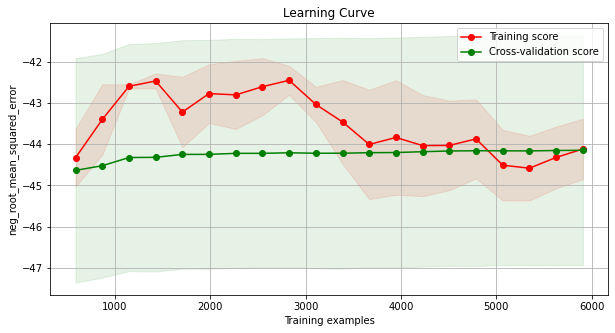

In [30]:
# uses the function to plot the performance of differnt training data set sizes (x axis)
# the training performance is typically ok to start because limited data easier to predict but harder with more data)
# cross validataion is usually not as good to start because model learned on so little it can't handle new data 
# but over time stabilizes
plot_learning_curve(model, X_train, y_train)

### Evaluate Model on Test Set

In [31]:
#use the linear regression model and evaluate the test data set
predictions = model.predict(X_test)

#compare the predicted to the actuals
rmse = mean_squared_error(y_test,predictions, squared=False)
print("Predition Error (RMSE): {:,.0f}".format(rmse))

Predition Error (RMSE): 45


### Look at Feature Importance for this Model

In [32]:
# for linear regression models, the coeffient of each attribute signifies its importance
# attributes was a variable created above; model.coef_ is a detail provided by the model

sorted(zip(model.coef_, attributes), reverse=True)

[(6.407901170186109, 'eau'),
 (4.328066423262834, 'online_only'),
 (3.468489324812353, 'cream'),
 (3.0056717230627727, 'set'),
 (2.302320496744032, 'extract'),
 (1.3756955050274706, 'rating'),
 (1.3617108317510178, 'limited_edition'),
 (1.2864470565283346, 'metha'),
 (0.5205054762271496, 'seed'),
 (0.20226435401570358, 'glycol'),
 (-1.7763568394002505e-15, 'limited_time_offer'),
 (-0.4480289333033949, 'love'),
 (-1.176924974534533, 'mask'),
 (-1.8281265912079978, 'sodium'),
 (-2.443462304696125, 'number_of_reviews'),
 (-2.5112987802307054, 'acid'),
 (-2.760334606211397, 'brush'),
 (-4.3981195801752655, 'lip'),
 (-4.781938523785883, 'oil'),
 (-6.785083037869634, 'mini'),
 (-7.509394131390888, 'exclusive')]

## <font color=purple>Train & Evaluate A List of Regression Model</font>

In [33]:
# feel free to comment out any models you do not wish to run (particularly the decision tree & random forest regressors)
modelList = [LinearRegression(),
             Ridge(random_state=42),
             Lasso(random_state=42),
             ElasticNet(random_state=42),
             SGDRegressor(random_state=42),              # needs at least 10K rows
             #ecisionTreeRegressor(random_state=42), 
             #RandomForestRegressor(random_state=42),     # most time consuming so may want to skip
             #GradientBoostingRegressor(random_state=42), # also one of the most time consuming algorithms 
             HistGradientBoostingRegressor(random_state=42), 
             KNeighborsRegressor()
            ]

for model in modelList: 

    #time how long a model needs "roughly" to learn
    print("-"*25)
    print(model)
    start_time = time.time()
    
    #fit the model to the prepared test data
    model.fit(X_train,y_train)

    #see how well the model fits
    #calculate the predicted values
    predictions = model.predict(X_train)

    #compare the predicted to the actuals
    rmse = mean_squared_error(y_train, predictions, squared=False)
    print(" Training Error (RMSE): {:,.0f}".format(rmse))
    
    #use cross valudation to process the data 5 different ways 
    scores = cross_val_score(model, X_train, y_train,
                         scoring="neg_root_mean_squared_error", cv=5)
      
    #calculate the average score over the 10 different cross validations
    print("Average CV Error (RMSE): {:,.0f}".format(-scores.mean()))
    print("Standard deviation: {:,.0f}".format( scores.std() ) )
    
    print("---> {:,.2f} seconds".format(time.time() - start_time))

-------------------------
LinearRegression()
 Training Error (RMSE): 44
Average CV Error (RMSE): 44
Standard deviation: 3
---> 0.09 seconds
-------------------------
Ridge(random_state=42)
 Training Error (RMSE): 44
Average CV Error (RMSE): 44
Standard deviation: 3
---> 0.05 seconds
-------------------------
Lasso(random_state=42)
 Training Error (RMSE): 44
Average CV Error (RMSE): 44
Standard deviation: 3
---> 0.16 seconds
-------------------------
ElasticNet(random_state=42)
 Training Error (RMSE): 45
Average CV Error (RMSE): 45
Standard deviation: 3
---> 0.12 seconds
-------------------------
SGDRegressor(random_state=42)
 Training Error (RMSE): 44
Average CV Error (RMSE): 44
Standard deviation: 3
---> 0.21 seconds
-------------------------
HistGradientBoostingRegressor(random_state=42)
 Training Error (RMSE): 37
Average CV Error (RMSE): 43
Standard deviation: 3
---> 27.66 seconds
-------------------------
KNeighborsRegressor()
 Training Error (RMSE): 37
Average CV Error (RMSE): 45


## <font color=purple>Take Best Model and Tune using GridSearch</font> 

In [41]:
# create a new Random Forest Regressor 
model = HistGradientBoostingRegressor( random_state=42 )

#create a parameter grid that determines the variable hyperparameters
param_grid = [   
    {'learning_rate': [.05], 
     'max_iter': [100],         #will add to processing time if allowing for more than normal iterations
     'l2_regularization': [0]
    }
]

# train across 5 folds
grid_search = GridSearchCV(model, param_grid, cv=5,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True)

#fit the model to the data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=HistGradientBoostingRegressor(random_state=42),
             param_grid=[{'l2_regularization': [0], 'learning_rate': [0.05],
                          'max_iter': [100]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [42]:
#let's look at the score of each hyperparameter combination tested during the grid search
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print('{:15,.2f} - {}'.format(-mean_score, params))

          42.55 - {'l2_regularization': 0, 'learning_rate': 0.05, 'max_iter': 100}


In [43]:
#display the parameters with the best solution (lowest score)
grid_search.best_params_

{'l2_regularization': 0, 'learning_rate': 0.05, 'max_iter': 100}

In [44]:
#display the best model and its parameters (similar to above but not in dictionary format)
grid_search.best_estimator_

HistGradientBoostingRegressor(l2_regularization=0, learning_rate=0.05,
                              random_state=42)

### Confirm that Tuning Produces a Better Result

In [45]:
#taking the best model so far and making it our final model
model = grid_search.best_estimator_

scores = cross_val_score(model, X_train, y_train,
                         scoring="neg_root_mean_squared_error", cv=5)

# look at the results of each fold
scores

array([-41.28776776, -43.16678994, -39.49615506, -47.6362129 ,
       -41.13971942])

In [46]:
print("Average of RMSE across folds: {:,.0f}".format(-scores.mean()))
print("Standard deviation: {:,.0f}".format( scores.std() ) )

Average of RMSE across folds: 43
Standard deviation: 3


### Review Learning Curve

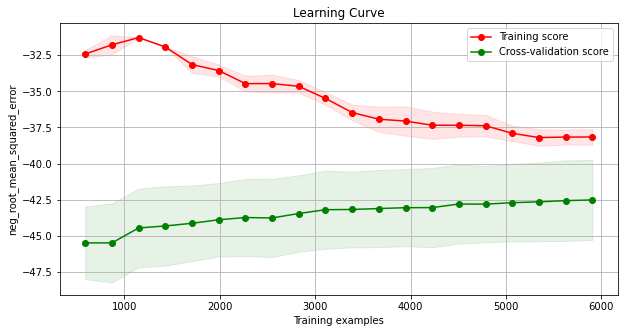

In [47]:
plot_learning_curve(model, X_train, y_train)

### Evaluate on the Test Set

In [48]:
#predict the test data set
predictions = model.predict(X_test)

#measure performance
rmse = mean_squared_error(y_test, predictions, squared=False)
print("TEST Predition Error (RMSE): {:,.0f}".format(rmse))

TEST Predition Error (RMSE): 42


In [49]:
#We can compute a 95% confidence interval for the test RMSE
confidence = 0.95
squared_errors = (predictions - y_test) ** 2
confidence_interval = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, 
                                               loc=squared_errors.mean(), scale=stats.sem(squared_errors)))
print( "{:.0f}% Confidence Intervals: {:,.2f} -- {:,.2f}".format(confidence*100, confidence_interval[0], confidence_interval[1]) )

95% Confidence Intervals: 37.64 -- 46.69


# Predictions

In [51]:
X_prepared=full_pipeline.transform(toPredict)
model.predict(X_prepared)

array([37.79395161, 61.52776331, 45.89496927])

# <font color=purple>Add Complexity using PolynomialFeatures

In [ ]:
#review the current shape of our training set
X_train.shape

### Add Complexity using Polynomial Features

In [ ]:
#try making a linear model fit data that is more likely non-linear
DEGREE = 2

#create a polynomial feature with degree based on variable DEGREE
poly_features=PolynomialFeatures(degree=DEGREE)

#transform our X by adding the square of each feature to the training set
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

X_train_poly.shape, X_test_poly.shape

## <font color=purple>Evaluate A List of Models with Polynomial Features~ 

In [ ]:
# feel free to comment out any models you do not wish to run 
modelList = [LinearRegression(),
             Ridge(random_state=42),
             Lasso(random_state=42),
             ElasticNet(random_state=42),
             SGDRegressor(random_state=42)
            ]

for model in modelList: 

    #time how long a model needs "roughly" to learn
    print("-"*25)
    print(model)
    start_time = time.time()
    
    #fit the model to the prepared test data
    model.fit(X_train_poly,y_train)

    #see how well the model fits
    #calculate the predicted values
    predictions = model.predict(X_train_poly)

    #compare the predicted to the actuals
    rmse = mean_squared_error(y_train, predictions, squared=False)
    print("Prediction Error (RMSE): {:,.0f}".format(rmse))
    
    #use cross valudation to process the data 5 different ways 
    scores = cross_val_score(model, X_train_poly, y_train,
                         scoring="neg_root_mean_squared_error", cv=5)
    
    #calculate the average score over the 10 different cross validations
    print("Average CV Error (RMSE): {:,.0f}".format(-scores.mean()))
    print("Standard deviation: {:,.0f}".format( scores.std() ) )
    
    print("---> {:,.2f} seconds".format(time.time() - start_time))

## <font color=purple>Take Best Model and Tune using GridSearch</font>

In [ ]:
# create a new Random Forest Regressor 
model = Ridge( random_state=42 )

#create a parameter grid that determines the variable hyperparameters
param_grid = [   
    {'alpha': [1, 1.5, 2], 
     'tol': [.01, .001], 
     'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'] 
    }]

# train across 5 folds
grid_search = GridSearchCV(model, param_grid, cv=5,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True)

#fit the model to the data
grid_search.fit(X_train_poly, y_train)

In [ ]:
#let's look at the score of each hyperparameter combination tested during the grid search
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print('{:,.2f} - {}'.format(-mean_score, params))

In [ ]:
#display the parameters with the best solution (lowest score)
grid_search.best_params_

In [ ]:
#display the best model and its parameters (similar to above but not in dictionary format)
grid_search.best_estimator_

### Confirm that Tuning Produces a Better Result

In [ ]:
#taking the best model so far and making it our final model
model = grid_search.best_estimator_
scores = cross_val_score(model, X_train_poly, y_train,
                         scoring="neg_root_mean_squared_error", cv=5)

# look at the results of each fold
scores

In [ ]:
print("Average of RMSE across folds: {:,.0f}".format(-scores.mean()))
print("Standard deviation: {:,.0f}".format( scores.std() ) )

### Evaluate on the Test Set

In [ ]:
#predict the test data set
predictions = model.predict(X_test_poly)

#measure performance
rmse = mean_squared_error(y_test, predictions, squared=False)
print("TEST Predition Error (RMSE): {:,.0f}".format(rmse))

In [ ]:
#We can compute a 95% confidence interval for the test RMSE
confidence = 0.95
squared_errors = (predictions - y_test) ** 2
confidence_interval = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, 
                                               loc=squared_errors.mean(), scale=stats.sem(squared_errors)))
print( "{:.0f}% Confidence Intervals: {:,.2f} -- {:,.2f}".format(confidence*100, confidence_interval[0], confidence_interval[1]) )

### Review Learning Curve

In [ ]:
plot_learning_curve(model, X_train_poly, y_train)